In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/My Drive/cvd

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import log_loss

encoder = preprocessing.LabelEncoder()

In [4]:
data = pd.read_csv('data.csv')
data = data.drop('id',axis=1)
data = data.fillna(np.nan,axis=0)
data['location'] = encoder.fit_transform(data['location'].astype(str))
data['country'] = encoder.fit_transform(data['country'].astype(str))
data['gender'] = encoder.fit_transform(data['gender'].astype(str))
data[['symptom1']] = encoder.fit_transform(data['symptom1'].astype(str))
data[['symptom2']] = encoder.fit_transform(data['symptom2'].astype(str))
data[['symptom3']] = encoder.fit_transform(data['symptom3'].astype(str))
data[['symptom4']] = encoder.fit_transform(data['symptom4'].astype(str))
data[['symptom5']] = encoder.fit_transform(data['symptom5'].astype(str))
data[['symptom6']] = encoder.fit_transform(data['symptom6'].astype(str))

In [5]:
data['sym_on'] = pd.to_datetime(data['sym_on'])
data['hosp_vis'] = pd.to_datetime(data['hosp_vis'])
data['sym_on']= data['sym_on'].map(dt.datetime.toordinal)
data['hosp_vis']= data['hosp_vis'].map(dt.datetime.toordinal)
data['diff_sym_hos']= data['hosp_vis'] - data['sym_on']

In [6]:
data['diff_symp_hos'] = data['hosp_vis']-data['sym_on']

In [7]:
data = data.drop(['sym_on','hosp_vis'],axis=1)

In [8]:
print(data.dtypes)

location           int32
country            int32
gender             int32
age              float64
vis_wuhan          int64
from_wuhan       float64
death              int64
recov              int64
symptom1           int32
symptom2           int32
symptom3           int32
symptom4           int32
symptom5           int32
symptom6           int32
diff_sym_hos       int64
diff_symp_hos      int64
dtype: object


###Visualization

In [9]:
import matplotlib.pyplot as plt
def counter2(colname1,colname2):
  colname1 = pd.Series(colname1)
  colname2 = pd.Series(colname2)
  count1 = 0
  for i in range(min([colname1.size,colname2.size])):
    if(colname1[i]==1 and colname2[i]==1):
      count1 = count1+1
  return count1

def counter1(colname):
  colname1 = pd.Series(colname)
  count = 0
  for i in range(colname1.size):
    if(colname1[i]==1):
      count = count+1
  return count

In [10]:
fwuh = counter1(data['from_wuhan'])
vwuh = counter1(data['vis_wuhan'])


In [11]:
print(counter1(data['death']))
print(counter2(data['from_wuhan'],data['death']))
print(counter2(data['vis_wuhan'],data['death']))

63
34
1


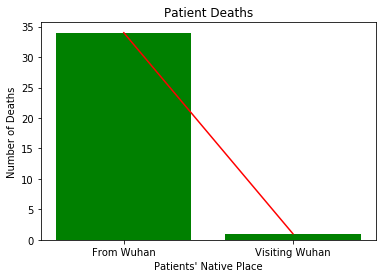

In [12]:
import matplotlib.pyplot as plt

plt.bar(['From Wuhan','Visiting Wuhan'],[counter2(data['death'],data['from_wuhan']),counter2(data['death'],data['vis_wuhan'])],color='green')
plt.title('Patient Deaths')
plt.xlabel('Patients\' Native Place')
plt.ylabel('Number of Deaths')
plt.plot([counter2(data['death'],data['from_wuhan']),counter2(data['death'],data['vis_wuhan'])],color='red')
plt.show()

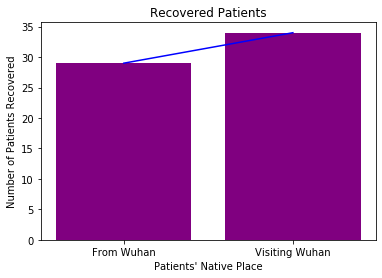

In [13]:
plt.bar(['From Wuhan','Visiting Wuhan'],[counter2(data['recov'],data['from_wuhan']),counter2(data['recov'],data['vis_wuhan'])],color='purple')
plt.title('Recovered Patients')
plt.xlabel('Patients\' Native Place')
plt.ylabel('Number of Patients Recovered')
plt.plot([counter2(data['recov'],data['from_wuhan']),counter2(data['recov'],data['vis_wuhan'])],color='blue')
plt.show()

###Training

In [14]:
tdata = pd.read_csv('train.csv')
print(tdata.head())

   id      location country gender   age      sym_on    hosp_vis  vis_wuhan  \
0  49  Wuhan, Hubei   China   male  61.0  12/20/2019  12/27/2019          0   
1  50  Wuhan, Hubei   China   male  69.0  12/30/2019    1/3/2020          0   
2  51  Wuhan, Hubei   China   male  89.0         NaN         NaN          0   
3  52  Wuhan, Hubei   China   male  89.0   1/13/2020   1/13/2020          0   
4  53  Wuhan, Hubei   China   male  66.0   1/10/2020   1/16/2020          0   

   from_wuhan  death symptom1 symptom2 symptom3  symptom4  symptom5  symptom6  
0           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
1           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
2           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
3           1      1      NaN      NaN      NaN       NaN       NaN       NaN  
4           1      1      NaN      NaN      NaN       NaN       NaN       NaN  


In [15]:
tdata = pd.read_csv('train.csv')
tdata = tdata.drop('id',axis=1)
tdata = tdata.fillna(np.nan,axis=0)
tdata['age'] = tdata['age'].fillna(value=tdata['age'].mean())
tdata['location'] = encoder.fit_transform(tdata['location'].astype(str))
tdata['country'] = encoder.fit_transform(tdata['country'].astype(str))
tdata['gender'] = encoder.fit_transform(tdata['gender'].astype(str))
tdata[['symptom1']] = encoder.fit_transform(tdata['symptom1'].astype(str))
tdata[['symptom2']] = encoder.fit_transform(tdata['symptom2'].astype(str))
tdata[['symptom3']] = encoder.fit_transform(tdata['symptom3'].astype(str))
tdata[['symptom4']] = encoder.fit_transform(tdata['symptom4'].astype(str))
tdata[['symptom5']] = encoder.fit_transform(tdata['symptom5'].astype(str))
tdata[['symptom6']] = encoder.fit_transform(tdata['symptom6'].astype(str))

In [16]:
tdata['sym_on'] = pd.to_datetime(tdata['sym_on'])
tdata['hosp_vis'] = pd.to_datetime(tdata['hosp_vis'])
tdata['sym_on']= tdata['sym_on'].map(dt.datetime.toordinal)
tdata['hosp_vis']= tdata['hosp_vis'].map(dt.datetime.toordinal)
tdata['diff_sym_hos']= tdata['hosp_vis'] - tdata['sym_on']

In [17]:
tdata = tdata.drop(['sym_on','hosp_vis'],axis=1)

In [18]:
print(tdata)

     location  country  gender        age  vis_wuhan  from_wuhan  death  \
0          38        2       1  61.000000          0           1      1   
1          38        2       1  69.000000          0           1      1   
2          38        2       1  89.000000          0           1      1   
3          38        2       1  89.000000          0           1      1   
4          38        2       1  66.000000          0           1      1   
..        ...      ...     ...        ...        ...         ...    ...   
217         2        3       2  49.747537          0           0      0   
218        22        6       2  49.747537          0           0      1   
219        22        6       2  49.747537          0           0      1   
220        22        6       2  49.747537          0           0      1   
221        22        6       2  49.747537          0           0      1   

     symptom1  symptom2  symptom3  symptom4  symptom5  symptom6  diff_sym_hos  
0           9      

In [19]:
print(tdata.isna().sum())

location        0
country         0
gender          0
age             0
vis_wuhan       0
from_wuhan      0
death           0
symptom1        0
symptom2        0
symptom3        0
symptom4        0
symptom5        0
symptom6        0
diff_sym_hos    0
dtype: int64


In [20]:
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import confusion_matrix as cm

In [21]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
classifier = AdaBoostClassifier(rf,50,0.01,'SAMME.R',10)

In [22]:
X = tdata[['location','country','gender','age','vis_wuhan','from_wuhan','symptom1','symptom2','symptom3','symptom4','symptom5','symptom6','diff_sym_hos']]
Y = tdata['death']

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
classifier.fit(X_train,np.array(Y_train).reshape(Y_train.shape[0],1))

C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=2,
                                          

In [24]:
pred = np.array(classifier.predict(X_test))

recall = rs(Y_test,pred)
precision = ps(Y_test,pred)
f1 = fs(Y_test,pred)
ma = classifier.score(X_test,Y_test)

In [25]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall)
print('Precision Score: ',precision)
print('F1 Score: ',f1)
print('Accuracy: ',ma)
a = pd.DataFrame(Y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  0.75
Precision Score:  1.0
F1 Score:  0.8571428571428571
Accuracy:  0.9333333333333333

	Table 3

     death  pred
130      0     0
203      0     0
170      1     0
66       0     0
181      0     0


In [26]:
print(pd.DataFrame({'Val':Y_test,'Pred':classifier.predict(X_test)}))

     Val  Pred
130    0     0
203    0     0
170    1     0
66     0     0
181    0     0
141    0     0
44     1     1
71     0     0
64     0     0
8      1     1
83     0     0
37     1     1
5      1     1
199    0     0
63     1     0
166    0     0
106    0     0
204    1     1
202    1     0
89     0     0
109    0     0
191    0     0
124    0     0
74     0     0
76     0     0
12     1     1
157    0     0
159    0     0
123    0     0
144    0     0
55     0     0
122    0     0
97     0     0
104    0     0
18     1     1
15     1     1
188    0     0
7      1     1
75     0     0
161    0     0
96     0     0
149    0     0
90     0     0
176    0     0
143    0     0


In [27]:
X1 = tdata[['location','country','gender','age','vis_wuhan','from_wuhan','symptom1','symptom2','symptom3','symptom4','symptom5','symptom6','diff_sym_hos']]
Y1 = tdata['death']
classifier1 = RandomForestClassifier()

n_estimators = [100,200,300,400,500]
max_depth = [1,2,5,6]
min_samples_split = [1,2,6,7]
min_samples_leaf = [2,3,4,5]

params_grid = {'n_estimators':n_estimators,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

gridder = GridSearchCV(estimator=classifier1,param_grid=params_grid,n_jobs=-1,cv=5,verbose=5 )
gridder.fit(X1,np.array(Y1).reshape(Y1.shape[0],1))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.8min finished
C:\Users\acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [28]:
print(gridder.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [29]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
udata = pd.read_excel('test.xlsx')
udata = udata.drop('id',axis=1)

In [31]:
print(udata.columns)

Index(['location', 'country', 'gender', 'age', 'sym_on', 'hosp_vis',
       'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2', 'symptom3',
       'symptom4', 'symptom5', 'symptom6'],
      dtype='object')


In [32]:
udata = udata.fillna(np.nan,axis=0)
udata['age'] = udata['age'].fillna(value=udata['age'].mean())
udata['from_wuhan'] = udata['from_wuhan'].fillna(value=0)
udata['from_wuhan'] = udata['from_wuhan'].astype(int)
udata['location'] = encoder.fit_transform(udata['location'].astype(str))
udata['country'] = encoder.fit_transform(udata['country'].astype(str))
udata['gender'] = encoder.fit_transform(udata['gender'].astype(str))
udata[['symptom1']] = encoder.fit_transform(udata['symptom1'].astype(str))
udata[['symptom2']] = encoder.fit_transform(udata['symptom2'].astype(str))
udata[['symptom3']] = encoder.fit_transform(udata['symptom3'].astype(str))
udata[['symptom4']] = encoder.fit_transform(udata['symptom4'].astype(str))
udata[['symptom5']] = encoder.fit_transform(udata['symptom5'].astype(str))
udata[['symptom6']] = encoder.fit_transform(udata['symptom6'].astype(str))

In [33]:
print(udata['from_wuhan'].mode())

0    0
dtype: int32


In [34]:
udata['sym_on'] = pd.to_datetime(udata['sym_on'])
udata['hosp_vis'] = pd.to_datetime(udata['hosp_vis'])
udata['sym_on']= udata['sym_on'].map(dt.datetime.toordinal)
udata['hosp_vis']= udata['hosp_vis'].map(dt.datetime.toordinal)
udata['diff_sym_hos']= udata['hosp_vis'] - udata['sym_on']

In [35]:
print(udata['from_wuhan'].unique())

[0 1]


In [36]:
print(udata.dtypes)

location          int32
country           int32
gender            int32
age             float64
sym_on            int64
hosp_vis          int64
vis_wuhan         int64
from_wuhan        int32
symptom1          int32
symptom2          int32
symptom3          int32
symptom4          int32
symptom5          int32
symptom6          int32
diff_sym_hos      int64
dtype: object


In [37]:
udata = udata[['location','country','gender','age','vis_wuhan','from_wuhan','symptom1','symptom2','symptom3','symptom4','symptom5','symptom6','diff_sym_hos']]
udata['result'] = classifier.predict(udata)

In [38]:
print(udata['result'])

0      1
1      0
2      0
3      0
4      0
      ..
858    1
859    0
860    0
861    0
862    0
Name: result, Length: 863, dtype: int64


In [39]:
#!cd '/gdrive/My Drive/cvd'

In [41]:
udata.to_csv('D:\Covid-19-Patient-Health-Analytics-master/final.csv')